# USCMS Diversity Data: `json` Consolidation
Combine various `json` files (`work_*.json`,`people_stats_*.json`,`people_new.json`) together that contain information on individuals:
* CMS ID 
* Gender
* Institution
* CMS Activity (Role)
* Project
* Author Status  

### Import Pythonic Libraries

In [1]:
import os, json
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import ipywidgets as widgets

### Select and Load in the Relevant `json` Files
Choose the years to consolidate

In [2]:
people_stats = [ option for option in os.listdir( "./Data/" ) if "people_stats" in option ]
work = [ option for option in os.listdir( "./Data/" ) if "work" in option ]
people_stats_years = [ name.split(".")[0].split("_")[2][:4] for name in people_stats ]
work_years = [ name.split(".")[0].split("_")[1][:4] for name in work ]
valid_years = list( set(people_stats_years).intersection(work_years) )
yearlist = widgets.SelectMultiple( options = sorted(valid_years) )
yearlist

SelectMultiple(options=('2015', '2016', '2017', '2018', '2019', '2020'), value=())

Load in the `json` files

In [56]:
json_files = {
    "people_new": json.load( open( "Data/people_new.json" ) ),
    "institutes_new": json.load( open( "Data/institutes_new.json" ) ),
    "people_stats": { year: json.load( open( "Data/people_stats_{}1231.json".format( year ) ) ) for year in yearlist.value },
    "work": { year: json.load( open( "Data/work_{}1231.json".format( year ) ) ) for year in yearlist.value }
}

Structure a single `dict` to track individuals per year.  The structure of the `dict` will be by layers:
1. Year
2. CMS ID
3. Gender, Author, Activity, Institute, Project  

Begin by structuring the individual `json` files by `YEAR` and `CMSID`, and then the relevant information as listed in bullet point 3.

Start with `people_new.json` to associate `CMSID` to `GENDER`:

In [57]:
people_new = {}
people_new_values = { "GENDER": [] }

for person in json_files[ "people_new" ]:
    people_new[ str( person[ "cmsId" ] ) ] = { "GENDER": person[ "gender" ] }
    people_new_values[ "GENDER" ].append( person[ "gender" ] )
    
print( ">> GENDER OPTIONS: {}".format( list( set( people_new_values[ "GENDER" ] ) ) ) )

>> GENDER OPTIONS: ['', None, 'F', 'M']


Use `work_*.json` to associate `CMSID` to `PROJECT`:

In [58]:
work = { year: {} for year in yearlist.value }
work_values = { year: { "PROJECT": [] } for year in yearlist.value }

for year in yearlist.value:
    work[ year ] = {}
    for institute in json_files[ "work" ][ year ]:
        for person in json_files[ "work" ][ year ][ institute ].keys():
            if person not in list( work[ year ].keys() ):
                work[ year ][ person ] = [ project.upper() for project in list( json_files[ "work" ][ year ][ institute ][ person ].keys() ) ]
            else:
                for project in list( json_files[ "work" ][ year ][ institute ][ person ].keys() ):
                    work[ year ][ person ].append( project.upper() )
            for project in list( json_files[ "work" ][ year ][ institute ][ person ].keys() ):
                work_values[ year ][ "PROJECT" ].append( project.upper() )
        
    print( ">> {} PROJECT OPTIONS: {}".format( year, sorted( list( set( work_values[ year ][ "PROJECT" ] ) ) ) ) )


>> 2015 PROJECT OPTIONS: ['BRIL', 'CT-PPS', 'DAQ', 'ECAL', 'GENERAL', 'HCAL', 'L1 TRIGGER', 'MUON-CSC', 'MUON-DT', 'MUON-RPC', 'OFFLINE AND COMPUTING', 'PPD', 'RUN COORDINATION', 'TRACKER', 'TRIGGER COORDINATION', 'UPGRADE']
>> 2016 PROJECT OPTIONS: ['BRIL', 'CT-PPS', 'DAQ', 'ECAL', 'GENERAL', 'HCAL', 'HGCAL', 'L1 TRIGGER', 'MUON', 'OFFLINE AND COMPUTING', 'PPD', 'RUN COORDINATION', 'TRACKER', 'TRIGGER COORDINATION', 'UPGRADE']
>> 2017 PROJECT OPTIONS: ['BRIL', 'CT-PPS', 'DAQ', 'ECAL', 'GENERAL', 'HCAL', 'L1 TRIGGER', 'MUON', 'OFFLINE AND COMPUTING', 'PPD', 'RUN COORDINATION', 'TRACKER', 'TRIGGER COORDINATION', 'UPGRADE']
>> 2018 PROJECT OPTIONS: ['BRIL', 'DAQ', 'ECAL', 'GENERAL', 'HCAL', 'HGCAL (CE)', 'L1 TRIGGER', 'MUON', 'OFFLINE AND COMPUTING', 'PPD', 'PPS', 'RUN COORDINATION', 'TRACKER', 'TRIGGER COORDINATION', 'UPGRADE']
>> 2019 PROJECT OPTIONS: ['BRIL', 'DAQ', 'ECAL', 'HCAL', 'HGCAL (CE)', 'L1 TRIGGER', 'MTD', 'MUON', 'OFFLINE SOFTWARE AND COMPUTING', 'PPD', 'PPS', 'RUN COORDINA

In [59]:
project_options = []
for year in yearlist.value:
    for project in list( set( work_values[ year ][ "PROJECT" ] ) ):
        if project not in project_options: project_options.append( project )
print( ">> {}-{} PROJECT OPTIONS:".format( yearlist.value[0], yearlist.value[-1] ) )
for project in sorted( project_options ):
    print( "  - {}".format( project ) )

>> 2015-2020 PROJECT OPTIONS:
  - BRIL
  - CT-PPS
  - DAQ
  - ECAL
  - GENERAL
  - HCAL
  - HGCAL
  - HGCAL (CE)
  - L1 TRIGGER
  - MTD
  - MUON
  - MUON-CSC
  - MUON-DT
  - MUON-RPC
  - OFFLINE AND COMPUTING
  - OFFLINE SOFTWARE AND COMPUTING
  - PPD
  - PPS
  - RUN COORDINATION
  - TRACKER
  - TRIGGER COORDINATION
  - UPGRADE


Use `people_stats_*.json` to associate `CMSID` and `ACTIVITY`, `INSTITUTE`, `AUTHOR`:

In [60]:
people_stats = { year: {} for year in yearlist.value }
people_stats_values = { year: {
    "ACTIVITY":  [],
    "INSTITUTE": [],
    "AUTHOR": []
} for year in yearlist.value }

for year in yearlist.value:
    people_stats[ year ] = {}
    for person in json_files[ "people_stats" ][ year ]:
        people_stats[ year ][ str( person[ "cms_id" ] ) ] = {
            "ACTIVITY":  person[ "activity_cms" ] if person[ "activity_cms" ] is not None else "Other",
            "INSTITUTE": person[ "inst_code" ],
            "AUTHOR":    person[ "is_author" ]
        }
        if person[ "activity_cms" ] is None: people_stats_values[ year ][ "ACTIVITY" ].append( "Other" )
        else: people_stats_values[ year ][ "ACTIVITY" ].append( person[ "activity_cms" ] )
        people_stats_values[ year ][ "INSTITUTE" ].append( person[ "inst_code" ] )
        people_stats_values[ year ][ "AUTHOR" ].append( person[ "is_author" ] )

    print( ">> {} ACTIVITY OPTIONS: {}".format( year, sorted( set( people_stats_values[ year ][ "ACTIVITY" ] ) ) ) )

>> 2015 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'Engineer Electronics', 'Engineer Mechanical', 'Engineer Software', 'Non-Doctoral Student', 'Other', 'Physicist', 'Technician', 'Theoretical Physicist']
>> 2016 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'Engineer Electronics', 'Engineer Mechanical', 'Engineer Software', 'Non-Doctoral Student', 'Other', 'Physicist', 'Technician', 'Theoretical Physicist']
>> 2017 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'Engineer Electronics', 'Engineer Mechanical', 'Engineer Software', 'Non-Doctoral Student', 'Other', 'Physicist', 'Technician', 'Theoretical Physicist']
>> 2018 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'Engineer Electronics', 'Engineer Mechanical', 'Engineer Software', 'Non-Doctoral Student', 'Other', 'Physicist', 'Technician', 'Theoretical Physicist']
>> 2019 ACTIVITY OPTIONS: ['Administrative', 'Doctoral Student', 'Engineer', 'En

In [61]:
activity_options = []
for year in yearlist.value:
    for activity in list( set( people_stats_values[ year ][ "ACTIVITY" ] ) ):
        if activity not in activity_options: activity_options.append( activity )
print( ">> {}-{} ACTIVITY OPTIONS:".format( yearlist.value[0], yearlist.value[-1] ) )
for activity in sorted( activity_options ):
    print( "  - {}".format( activity ) )

>> 2015-2020 ACTIVITY OPTIONS:
  - Administrative
  - Doctoral Student
  - Engineer
  - Engineer Electronics
  - Engineer Mechanical
  - Engineer Software
  - Non-Doctoral Student
  - Other
  - Physicist
  - Technician
  - Theoretical Physicist


### `json` File Statistics
List the possible options for each of the categories and provide some basic plots on the distributions of the options.  

Plot the genders of all existing and past CMS members.

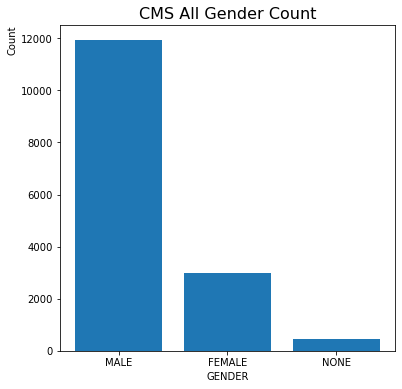

In [62]:
gender_keys = [ "MALE", "FEMALE", "NONE" ]
gender_plot = { key: 0 for key in gender_keys }
for gender in people_new_values[ "GENDER" ]:
    if gender is None or gender == "":
        gender_plot[ "NONE" ] += 1
    elif gender.upper() == "F":
        gender_plot[ "FEMALE" ] += 1
    elif gender.upper() == "M":
        gender_plot[ "MALE" ] += 1

plt.figure( figsize = (6,6) )
plt.bar( list( gender_plot.keys() ), list( gender_plot.values() ) )
plt.title( "CMS All Gender Count", fontsize = 16 )
plt.ylabel( "Count", y = 1.0, ha = "right" )
plt.xlabel( "GENDER" )
plt.show()

Plot the number of members within each project grouped by year.  First, choose a project to view:

In [63]:
project_choice = widgets.Dropdown( options = project_options )
project_choice

Dropdown(options=('UPGRADE', 'TRACKER', 'MUON-DT', 'OFFLINE AND COMPUTING', 'MUON-CSC', 'GENERAL', 'L1 TRIGGER…

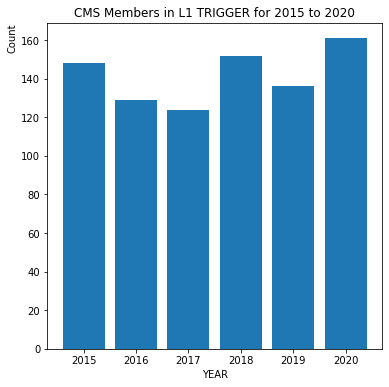

In [65]:
project_plot = { year: 0 for year in yearlist.value }
for year in yearlist.value:
    for project in work_values[ year ][ "PROJECT" ]:
        if project == project_choice.value:
            project_plot[ year ] += 1
        
plt.figure( figsize = (6,6) )

plt.bar( list( project_plot.keys() ), list( project_plot.values() ) )
plt.title( "CMS Members in {} for {} to {}".format( project_choice.value, yearlist.value[0], yearlist.value[-1] ) )
plt.ylabel( "Count", y = 1.0, ha = "right" )
plt.xlabel( "YEAR" )
plt.show()

Plot the number of members based on `ACTIVITY` grouped by year. First, choose an activity to view:

In [66]:
activity_choice = widgets.Dropdown( options = activity_options )
activity_choice

Dropdown(options=('Non-Doctoral Student', 'Theoretical Physicist', 'Engineer Electronics', 'Administrative', '…

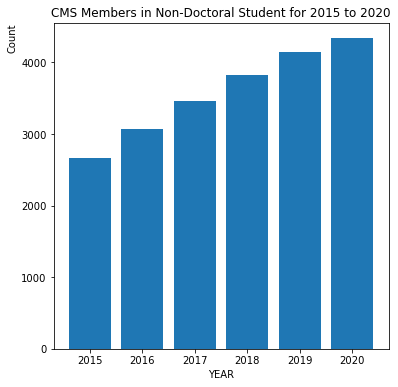

In [67]:
activity_plot = { year: 0 for year in yearlist.value }
for year in yearlist.value:
    for activity in people_stats_values[ year ][ "ACTIVITY" ]:
        if activity == activity_choice.value:
            activity_plot[ year ] += 1
        
plt.figure( figsize = (6,6) )

plt.bar( list( activity_plot.keys() ), list( activity_plot.values() ) )
plt.title( "CMS Members in {} for {} to {}".format( activity_choice.value, yearlist.value[0], yearlist.value[-1] ) )
plt.ylabel( "Count", y = 1.0, ha = "right" )
plt.xlabel( "YEAR" )
plt.show()

### Format and Produce New `json` File
Compile the new `dict`

In [68]:
combined_json = { year: {} for year in yearlist.value }

for year in yearlist.value:
    for ID in sorted( list( set( people_stats[ year ].keys() ).intersection( set( work[ year ].keys() ) ) ) ):
        combined_json[ year ][ str(ID) ] = {}
        combined_json[ year ][ str(ID) ][ "GENDER" ] = people_new[ str(ID) ][ "GENDER" ]
        if str(ID) in work[ year ].keys():
            combined_json[ year ][ str(ID) ][ "PROJECT" ] = work[ year ][ str(ID) ]
        else:
            combined_json[ year ][ str(ID) ][ "PROJECT" ] = [ "OTHER" ]
        if str(ID) in people_stats[ year ].keys():
            combined_json[ year ][ str(ID) ][ "ACTIVITY" ]  = people_stats[ year ][ str(ID) ][ "ACTIVITY" ]
            combined_json[ year ][ str(ID) ][ "INSTITUTE" ] = people_stats[ year ][ str(ID) ][ "INSTITUTE" ]
            combined_json[ year ][ str(ID) ][ "AUTHOR" ]    = people_stats[ year ][ str(ID) ][ "AUTHOR" ]
        else:
            combined_json[ year ][ str(ID) ][ "ACTIVITY" ]  = "OTHER"
            combined_json[ year ][ str(ID) ][ "INSTITUTE" ] = "OTHER"
            combined_json[ year ][ str(ID) ][ "AUTHOR" ]    = None

Dump the `json` file

In [69]:
with open( "json_analysis.json", "w" ) as outfile:
    json.dump( combined_json, outfile, indent = 2 )